# What are the most frequently run reports?

>Questions being answered in this notebook.
>- [x] What is the most run report?

In [1]:
import pandas as pd

Loading active reports data.

In [2]:
active_reports = pd.read_csv("datasets/active_reports.csv", low_memory=False)

In [3]:
active_reports.shape

(6524, 20)

In [4]:
# list(active_reports.columns)

In [5]:
interest_columns = ['Id', 'Name']

Loading report event logs.

In [6]:
report_logs = pd.read_csv("../data/Salesforce/ELF/Report/2022-06-04_Report.csv", low_memory=False)

In [7]:
ltng_report_logs = report_logs[report_logs.ORIGIN == 'ReportRunFromLightning']

Reports run frequency.

In [8]:
full_report_logs = pd.merge(left=active_reports, right=ltng_report_logs, left_on="Id", right_on="REPORT_ID_DERIVED")

In [9]:
full_report_logs.Name.value_counts(sort=True)

New Email By Team - w\o Sup filter       8816
My Cases and Tasks                       6835
S&AS Reactive Queues                     2347
New Email By Team_HYD                    2293
Wipro - VxRail Case Title Report         1392
                                         ... 
ESG_SRO_DRM Cases in Routing Queue          1
[WorkOrders] - AP Open Backlog Status       1
LDell - Routing Payload                     1
JP TechRoles Skills and C                   1
HES NCC by RSE/GSE                          1
Name: Name, Length: 324, dtype: int64

In [10]:
run_frequency = full_report_logs.Name.value_counts(sort=True)

<AxesSubplot:>

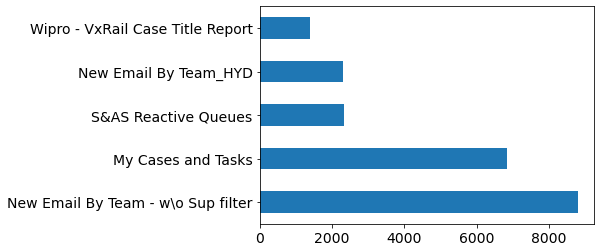

In [11]:
run_frequency\
    .head(5)\
    .plot(kind='barh', fontsize=14)

In [12]:
run_frequency.mean()

118.29012345679013

In [13]:
run_frequency.median()

6.0

In [14]:
import matplotlib.pyplot as plt

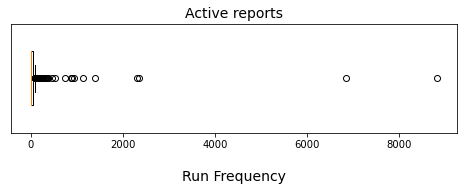

In [15]:
fig = plt.figure(figsize=(8,2))
plt.boxplot(run_frequency.values, vert=False, widths=[.5])
plt.title('Active reports', fontsize=14)
plt.xlabel('\nRun Frequency', fontsize=14)
plt.yticks([])
plt.show()

Removing the outlier report.

In [16]:
run_frequency\
    .drop(full_report_logs.Name.value_counts(sort=True).index[0])\
    .mean()

91.36222910216718

In [17]:
run_frequency\
    .drop(full_report_logs.Name.value_counts(sort=True).index[0]).median()

6.0

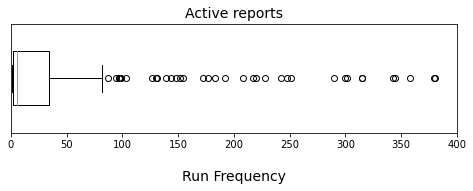

In [18]:
fig = plt.figure(figsize=(8,2))
plt.boxplot(run_frequency.drop(run_frequency.index[0]).values, vert=False, widths=[.5])
plt.title('Active reports', fontsize=14)
plt.xlabel('\nRun Frequency', fontsize=14)
plt.xlim(0, 400)
plt.yticks([])
plt.show()

In [19]:
most_run_reports = full_report_logs[['Id', 'Name']].value_counts(sort=True)

In [20]:
top5_most_run_reports = most_run_reports.reset_index().rename(columns={0: 'RunCount'}).head()

In [21]:
# top5_most_run_reports

## Analysis on PageView logs

Getting information about PageView of these most frequently run reports.

In [22]:
pageview_logs = pd.read_csv("../data/Salesforce/ELF/LightningPageView/2022-06-04_LightningPageView.csv")

C:\Users\jefer\AppData\Local\Temp\ipykernel_3488\1025747663.py:1: DtypeWarning: Columns (5,11,13,17,18,19,20,22,24,28,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  pageview_logs = pd.read_csv("../data/Salesforce/ELF/LightningPageView/2022-06-04_LightningPageView.csv")


In [23]:
pageview_logs.shape

(792349, 50)

In [24]:
# list(pageview_logs.columns)

Selecting the information we need.

In [25]:
pageview_features = ['PAGE_ENTITY_ID', 'PAGE_ENTITY_TYPE', 'PAGE_CONTEXT', 'PAGE_APP_NAME', 
                     'APP_NAME', 'PAGE_START_TIME', 'PAGE_URL', 'USER_ID_DERIVED', 'USER_TYPE', 
                     'UI_EVENT_SOURCE', 'DURATION', 'EFFECTIVE_PAGE_TIME', 'EFFECTIVE_PAGE_TIME_DEVIATION', 
                     'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE', 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON', 
                     'GRANDPARENT_UI_ELEMENT']

In [26]:
pageview_logs = pageview_logs[pageview_features]

In [27]:
pageview_logs.shape

(792349, 16)

Removing missing values for `PAGE_URL`.

In [28]:
pageview_logs.dropna(subset=['PAGE_URL'], inplace=True)

In [29]:
pageview_logs.shape

(789728, 16)

In [30]:
import re

pattern = re.compile(r'\/lightning\/r\/(?P<report_type>[a-zA-Z]{4,})\/(?P<report_id>[0-9a-zA-Z]{18})')

def filter_run_report_endpoints(pattern, url):
    m = re.match(pattern, url)
    if m:
        return m.group('report_id')

In [31]:
pageview_logs['REPORT_ID_DERIVED'] = pageview_logs.PAGE_URL.apply(lambda url: filter_run_report_endpoints(pattern, url))

Removing missing values after endpoint filter.

In [32]:
pageview_logs.dropna(subset=['REPORT_ID_DERIVED'], inplace=True)

In [33]:
pageview_logs.shape

(478779, 17)

Cleaning data by removing inconsistent report IDs.

In [34]:
pageview_logs = pageview_logs[pageview_logs.REPORT_ID_DERIVED.str.len()==18]

In [35]:
pageview_logs.shape

(478779, 17)

In [36]:
top5_most_run_reports.reset_index()

,index,Id,Name,RunCount
0,0,00O0b000006iNwdEAE,New Email By Team - w\o Sup filter,8816
1,1,00O0b000004kTazEAE,My Cases and Tasks,6708
2,2,00O2R000004AmwmUAC,S&AS Reactive Queues,2347
3,3,00O2R000003JCXaUAO,New Email By Team_HYD,2293
4,4,00O6P000000ZMcoUAG,Wipro - VxRail Case Title Report,1392


Active most run report pageview data.

In [37]:
active_most_run_reports_pageview_logs =\
    pd.merge(left=top5_most_run_reports, right=pageview_logs, left_on='Id', right_on='REPORT_ID_DERIVED')

In [38]:
active_most_run_reports_pageview_logs[['Id', 'Name']]\
    .value_counts(sort=True)\
    .reset_index()\
    .rename(columns={0: 'PageViewLogs'})

,Id,Name,PageViewLogs
0,00O0b000004kTazEAE,My Cases and Tasks,5561
1,00O0b000006iNwdEAE,New Email By Team - w\o Sup filter,5502
2,00O2R000004AmwmUAC,S&AS Reactive Queues,935
3,00O2R000003JCXaUAO,New Email By Team_HYD,779
4,00O6P000000ZMcoUAG,Wipro - VxRail Case Title Report,515


Most run reports average duration.

In [39]:
active_most_run_reports_pageview_logs[['Id', 'Name', 'DURATION']]\
    .groupby(['Id', 'Name'])\
    .agg('mean')\
    .rename(columns={'DURATION': 'AverageDuration'})\
    .sort_values(by='AverageDuration', ascending=False)\
    .reset_index()

,Id,Name,AverageDuration
0,00O6P000000ZMcoUAG,Wipro - VxRail Case Title Report,22574.075728
1,00O2R000004AmwmUAC,S&AS Reactive Queues,16060.443850
2,00O2R000003JCXaUAO,New Email By Team_HYD,5364.430039
3,00O0b000006iNwdEAE,New Email By Team - w\o Sup filter,4444.003090
4,00O0b000004kTazEAE,My Cases and Tasks,2719.097105
